In [19]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import os
import visualkeras


import tensorflow as tf
from keras import Input, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D, MaxPooling2D, SeparableConv2D)
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model


# IGNORE TENSORFLOW WARNING CAUSED OF GPU
import warnings
warnings.filterwarnings('ignore')

In [2]:
# constant
IMAGE_PATH = '../data/motif-sasirangan/Turun Dayang/Picsart_23-03-04_22-24-22-276.jpg'
BATCH_SIZE = 216
DATA_DIR = '../data/motif-sasirangan'
IMAGE_SIZE = (128, 128)

# Table of Contents
- Image (Citra)
- Split dataset (metode Stratified Shuffle Split)
- CNN
- Metric Evaluations

# Overview

## 1. Image RGB Visualization

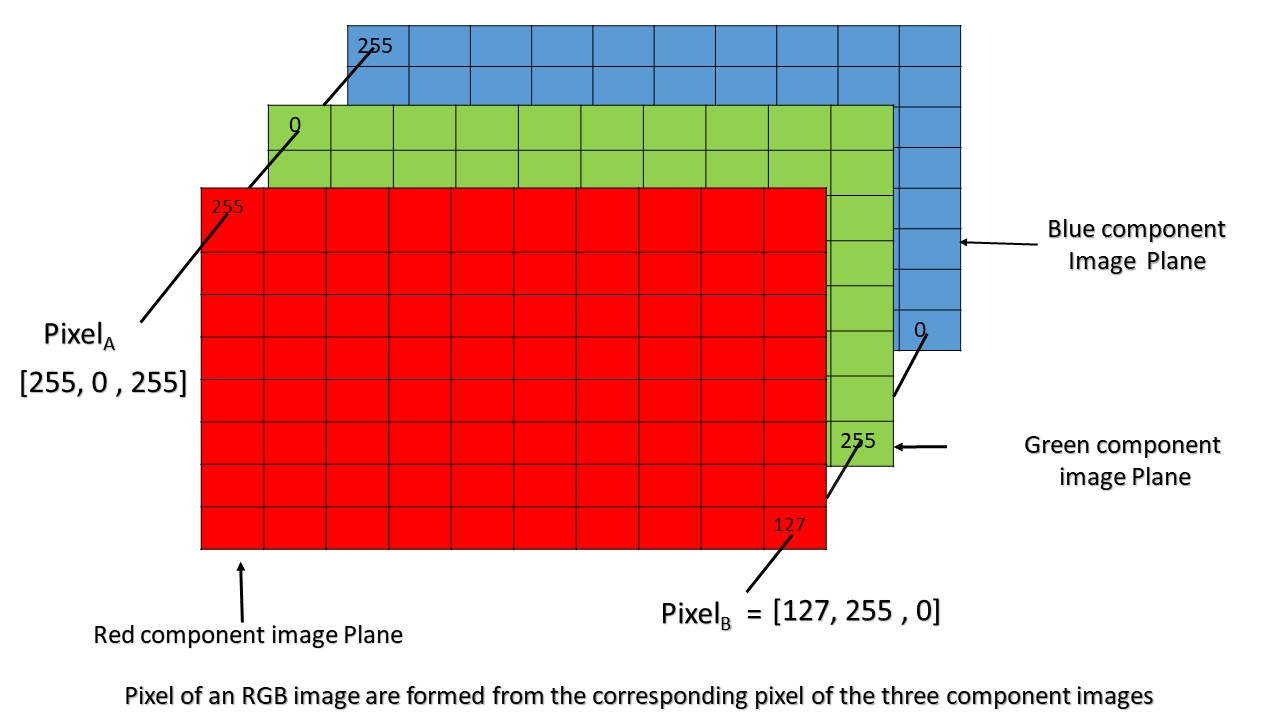


## 2. Vector vs Matrix vs Tensor
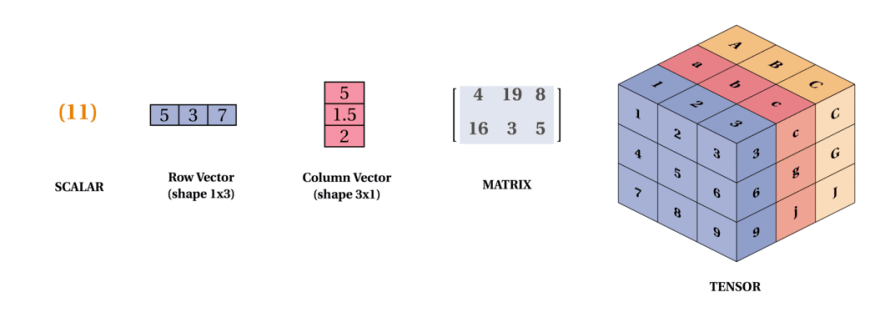

# 1. Preprocessing
- resize image 180 x 180
- scalled image pixel

In [3]:
sample_img = np.asarray(Image.open(IMAGE_PATH))
print("image in array representation: ")
print("===============================")
print(repr(sample_img[100]))

image in array representation: 
array([[148, 136, 136],
       [ 87,  76,  74],
       [129, 118, 116],
       ...,
       [ 57,  53,  52],
       [ 62,  58,  59],
       [ 63,  59,  60]], dtype=uint8)


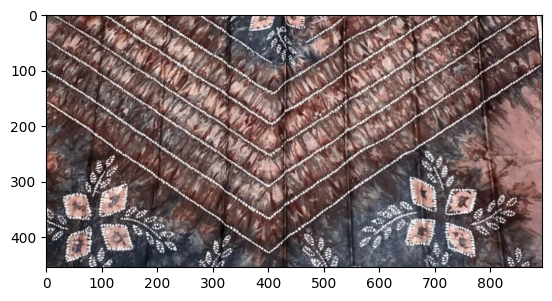

In [4]:
# display the image
imgplot = plt.imshow(sample_img)

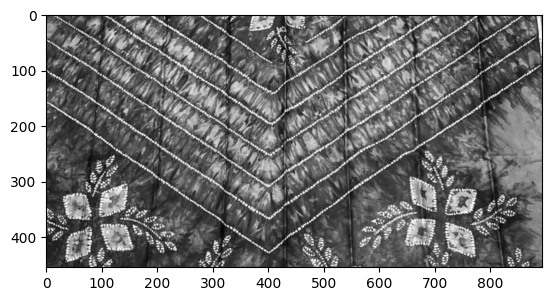

In [5]:
gray_img=cv2.imread(IMAGE_PATH, 0)
plt.imshow(gray_img, cmap="gray")

## Resize Image
Those sample images will resized to 180x180

In [6]:
resized_sample_img = cv2.resize(sample_img, (180, 180))
print('before resized: ', sample_img.shape)
print('resized sample image shape: ', resized_sample_img.shape)

before resized:  (455, 894, 3)
resized sample image shape:  (180, 180, 3)


In [7]:
resized_gray_img = cv2.resize(gray_img, (10, 10))
print('before resized: ', resized_gray_img.shape)
print('resized sample image shape: ', resized_gray_img.shape)

before resized:  (10, 10)
resized sample image shape:  (10, 10)


## Scaled Image
Divide all pixel values with 255

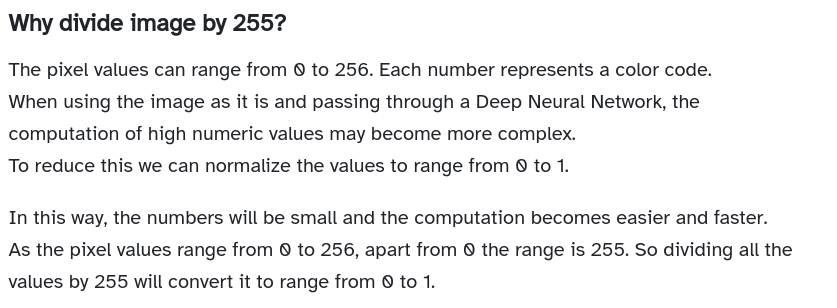

source: https://devskrol.com/2021/02/20/a-tip-a-day-python-tip-8-normalize-image-pixel-values-or-divide-by-255/

**Pixel value before divided by 255**

<Axes: >

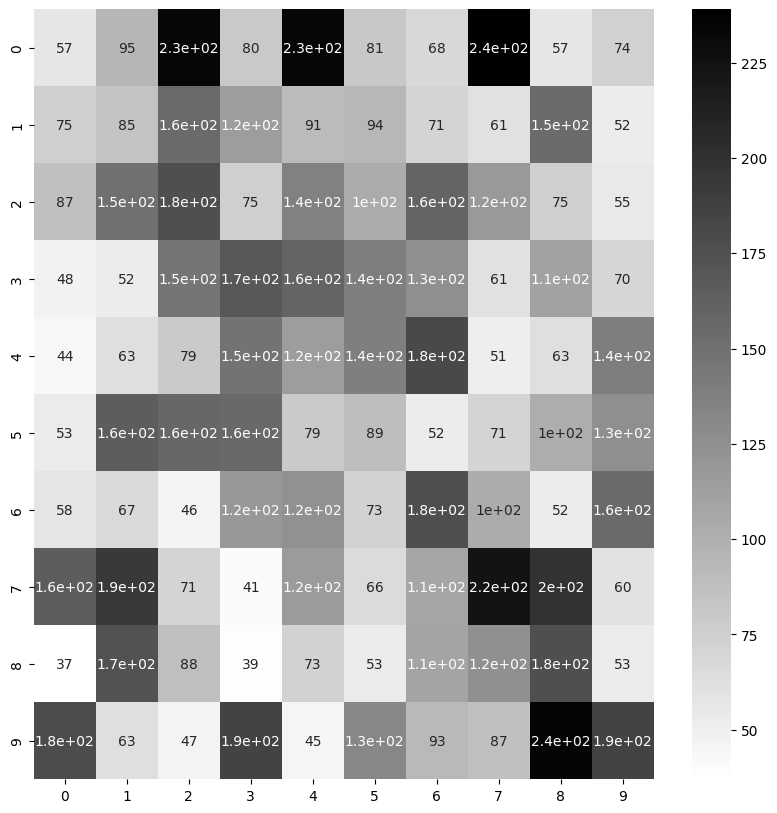

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(resized_gray_img, annot= True, cmap="binary")

**Pixel value after divided by 255**

<Axes: >

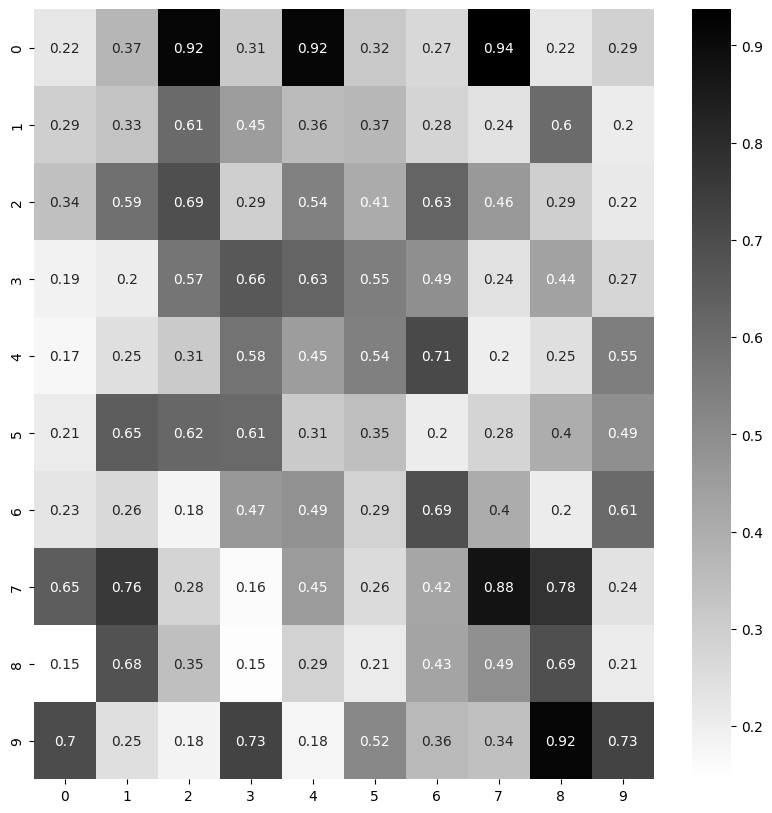

In [9]:
resized_gray_img = resized_gray_img / 255
plt.figure(figsize=(10,10))
sns.heatmap(resized_gray_img, annot= True, cmap="binary")

In [10]:
scaled_sample_img = sample_img / 255
scaled_sample_img[100]

array([[0.58039216, 0.53333333, 0.53333333],
       [0.34117647, 0.29803922, 0.29019608],
       [0.50588235, 0.4627451 , 0.45490196],
       ...,
       [0.22352941, 0.20784314, 0.20392157],
       [0.24313725, 0.22745098, 0.23137255],
       [0.24705882, 0.23137255, 0.23529412]])

## 2. Data Augmentations

Augmentasi data dengan proses transformasi geometri berupa rotasi gambar, penggeseran, pembesaran, *shearing*, dan horizontal flip secara random pada setiap gambar dengan rentang parameter yang telah ditentukan.

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

### Paramater Description

`rotation_range`: This parameter specifies the range of random rotations to apply to the image, in degrees. In this case, the range is set to 15 degrees, meaning that the image can be rotated up to 15 degrees in either direction

`rescale`: This parameter rescales the pixel values of the input image to a specified range. In this case, the value is set to 1/255, which means that the pixel values are divided by 255 to normalize them to the range [0, 1].

`shear_range`: This parameter specifies the range of random shearing to apply to the image. Shearing is a type of distortion that moves one part of the image in a direction perpendicular to the image plane. In this case, the range is set to 0.1, meaning that the image can be sheared up to 10% in either direction.

`zoom_range`: This parameter specifies the range of random zoom to apply to the image. Zooming is a type of transformation that makes the image appear closer or further away. In this case, the range is set to 0.2, meaning that the image can be zoomed in or out by up to 20%.

`horizontal_flip`: This parameter specifies whether to randomly flip the image horizontally. In this case, the value is set to True, which means that the image can be flipped horizontally with a 50% probability.

`width_shift_range`: This parameter specifies the range of random horizontal shifts to apply to the image. In this case, the range is set to 0.1, meaning that the image can be shifted horizontally up to 10% of its width in either direction.

`height_shift_range`: This parameter specifies the range of random vertical shifts to apply to the image. In this case, the range is set to 0.1, meaning that the image can be shifted vertically up to 10% of its height in either direction.

In [12]:
def to_dataframe(data_dir):
    img_class_list = os.listdir(data_dir)
    img_path_list = []
    category_list = []
    for img_class in img_class_list:
        for img in os.listdir(os.path.join(data_dir, img_class)):
            img_path = os.path.join(data_dir, img_class, img)
            category_list.append(img_class)
            img_path_list.append(img_path)

    df = pd.DataFrame({
        'file_path': img_path_list,
        'category': category_list
    })

    return df

In [13]:
df = to_dataframe(DATA_DIR)

In [14]:
generator = datagen.flow_from_dataframe(
    df,
    x_col='file_path',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=(BATCH_SIZE)
)

Found 642 validated image filenames belonging to 5 classes.


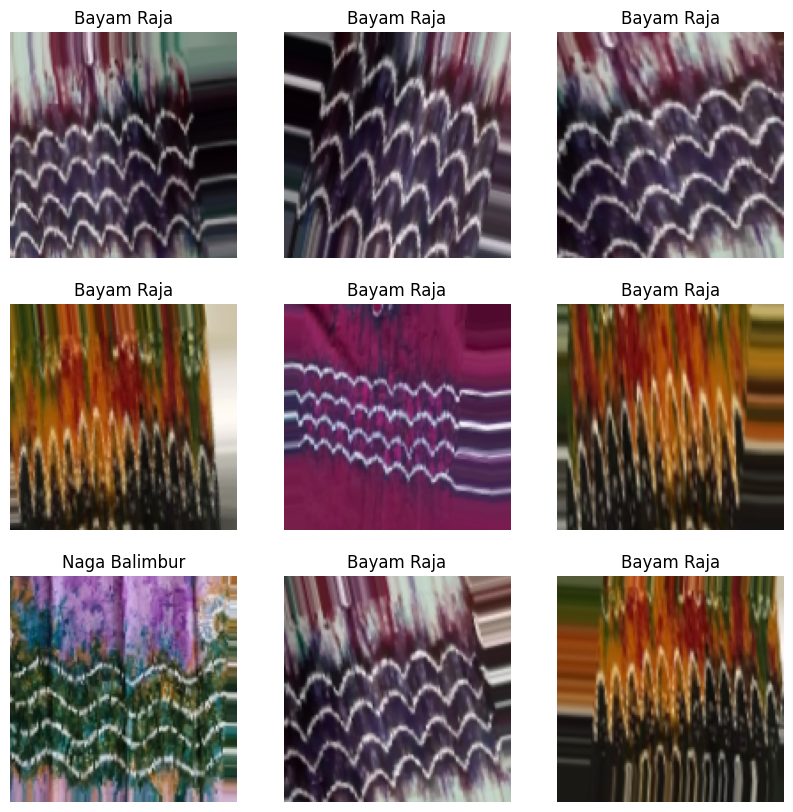

In [15]:
# Get class names
class_names = list(generator.class_indices.keys())

augmented_images, labels = generator.next()
# Plot the first 9 images
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for i in range(9):
    axs[i].imshow(augmented_images[i])
    axs[i].set_title(class_names[np.argmax(labels[i])])
    axs[i].axis('off')
    
plt.show()

# CNN Explanations

1. Convolutional Layer

Layer yang mengambil data image dan mengaplikasikannya ke dalam sebuah kernel/filter yang bergeser di atas image. Kernel tersebut kemudian melakukan ekstraksi fitur dengan cara melakukan dot-product. Hasil dari dot-product ini kemudian diteruskan ke layer selanjutnya. Setiap kernel dari layer konvolusi mempunya weight sebesar dari ukuran kernel tersebut yang kemudian akan berubah-ubah menggunakan *backpropagation*.


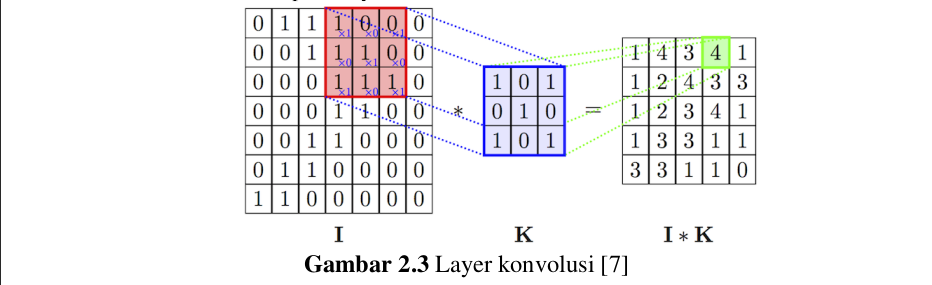

2. Pooling layer

Layer Pooling digunakan untuk downsampling matrix gambar, sehingga harga dari arsitektur berkurang. Layer ini tidak memiliki weight, dan hanya bertindak sebagai filter/ kernel.

3. Fully-Connected Layer (FC Layer)

FC Layer pada CNN sama pada dasarnya dengan FC yang terdapat pada neural network lainnya. FC dan Convolution layer memiliki fungsi yang mirip dalam melakukan training dan menyimpan weight dari model. Namun, dikarenakan hanya mendukung data

4. Dropout Layer

Dropout layer dimasukkan untuk mematikan neuron secara random pada layer sebelumnya (biasanya ditaruh setelah fully-connected layer). Penggunaan dropout layer umumnya dilakukan untuk mencegah overfitting akibat neuron yang terlalu bergantung antar satu sama lain. Akibatnya, dihasilkan model yang lebih independent dan fleksibel, dengan performa training yang meningkat.

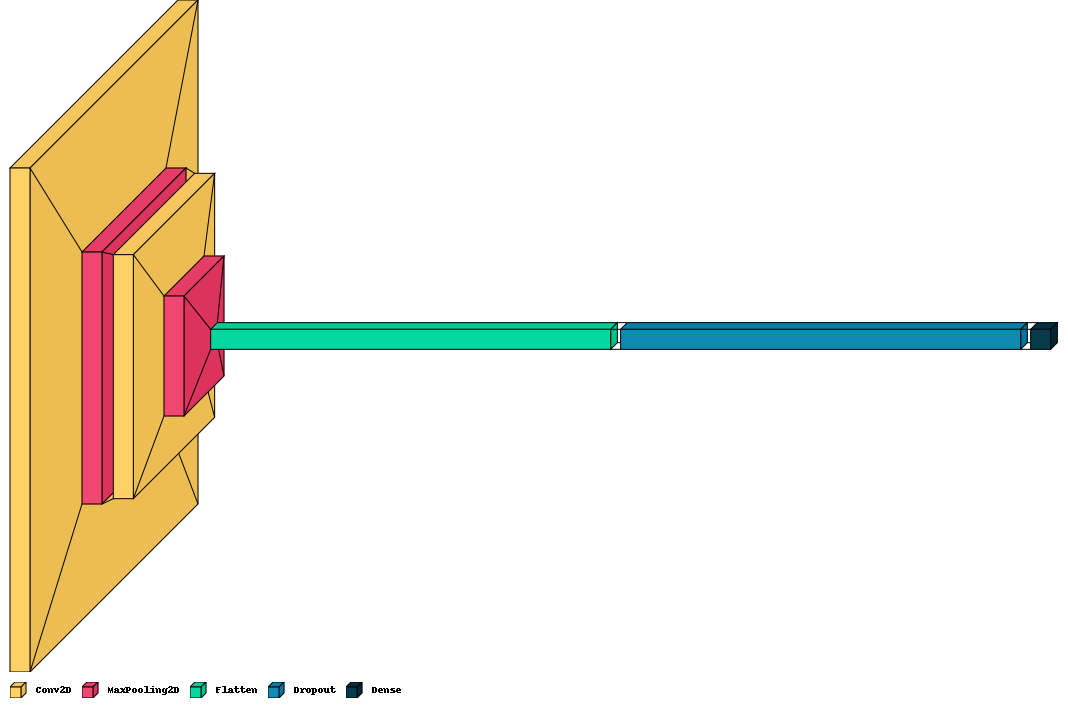

In [18]:
def construct_model(image_size: list, act='relu'):
  # Define the model architecture
  model = Sequential()

  # Add the first convolutional layer
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)))
  model.add(MaxPooling2D((2, 2)))

  # Add the second convolutional layer
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Flatten the output from the convolutional layers
  model.add(Flatten())
  model.add(Dropout(0.5))

  # Add the output layer
  model.add(Dense(5, activation='softmax'))

  return model

model_cnn = construct_model(IMAGE_SIZE)
visualkeras.layered_view(model_cnn, legend=True)

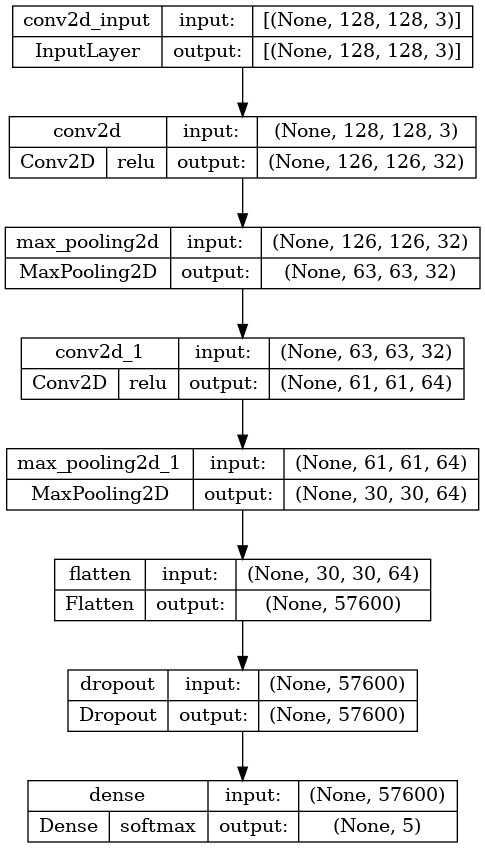

In [17]:
tf.keras.utils.plot_model(
model_cnn,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)